# Quantum Bayesian Inference

## Overview
This notebook demonstrates a quantum Bayesian inference (QBI) implementations provided in `qiskit-machine-learning`, and how it can be integrated into basic quantum machine learning (QML) workflows.

The tutorial is structured as follows:

1. [Introduction](#1.-introduction)
2. [How to Instantiate QBI](#2.-how-to-instantiate-qbi)
3. [How to Run Rejection Sampling](#3.-how-to-run-rejection-sampling)
4. [How to Run an Inference](#4.-how-to-run-an-inference)

## 1. Introduction

### 1.1. Quantum vs. Classical Bayesian Inference

Bayesian networks, or belief networks, are graphical models that illustrate probabilistic relationships between variables using nodes (representing variables) and edges (indicating conditional dependencies) in a directed acyclic graph. Each node is associated with conditional probability tables (CPTs) that detail the influence of parent nodes on their children. 

In these networks, Bayesian inference is key for updating probabilities. It employs Bayes' theorem to revise the likelihood of hypotheses based on new data, considering the network's variable interdependencies. For instance, in a network assessing diseases based on symptoms, observing new symptoms allows for recalculating disease probabilities. This recalibration combines the disease's prior probability with the observed symptom likelihood, leading to an updated, more precise disease probability. Thus, Bayesian inference is a dynamic process of adjusting our understanding of one variable in light of new information about others, facilitating informed, evidence-based decisions.

Exact inference on Bayesian networks is \#P-hard. That is why usually approximate inference is used to sample from the distribution on query variables given evidence variables. QBI efficiently utilizes the structure of Bayesian networks represented by a quantum circuit that represent the probability distributions. By employing a quantum version of rejection sampling and leveraging amplitude amplification, quantum computation achieves a significant speedup, making it possible to obtain samples much faster. 

This tutorial will guide you through the process of using the QBayesian class to perform such inference tasks. This inference algorithm implements the algorithm from the paper "Quantum inference on Bayesian networks" by Low, Guang Hao et al. This leads to a speedup per sample from $O(nmP(e)^{-1})$ to $O(n2^{m}P(e)^{-\frac{1}{2}})$, where n is the number of nodes in the Bayesian network with at most m parents per node and e the evidence.

### 1.2. Implementation in `qiskit-machine-learning`

The QBI in `qiskit-machine-learning` can be used for different quantum circuits representing Bayesian networks with. The implementation is based on the `Sampler` primitive from [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html). The primitive is the entry point to run QBI on either a simulator or real quantum hardware. QBI takes in an optional instance of its corresponding primitive, which can be any subclass of `BaseSampler`.

The `qiskit.primitives` module provides a reference implementation for the `Sampler` class to run statevector simulations. By default, if no instance is passed to a QBI class, an instance of the corresponding reference primitive of `Sampler` is created automatically by QBI.
For more information about primitives please refer to the [primitives documentation](https://qiskit.org/documentation/apidoc/primitives.html).

The `QBayesian` class is used for QBI in `qiskit-machine-learning`. It is initialized with a quantum circuit that represents a Bayesian network. This enables the execution of quantum rejection sampling and inference.


## 2. How to Instantiate QBI

### 2.1. Create Rotations for the Bayesian Networks
In quantum computing, the rotation matrix around the y-axis, denoted as $R_y(\theta)$, is used to rotate the state of a qubit around the y-axis of the Bloch sphere by an angle $\theta$. This approach allows for precise control over the quantum state of a qubit, enabling the encoding of specific probabilities in quantum algorithms. When this rotation is applied to a qubit initially in the $|0\rangle$ state, the resulting state $|\psi\rangle$ is:
$$ |\psi\rangle = R_y(\theta)|0\rangle = \begin{pmatrix} \cos\left(\frac{\theta}{2}\right) \\ \sin\left(\frac{\theta}{2}\right) \end{pmatrix} $$

where

* $R_y(\theta) = \begin{pmatrix} \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\ \sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) \end{pmatrix}$


This state is a superposition of $|0\rangle$ and $|1\rangle$ with respective amplitudes $\cos\left(\frac{\theta}{2}\right) $ and $\sin\left(\frac{\theta}{2}\right) $. To set a specific probability $p$ for measuring the qubit in the $|1\rangle$ state, you can determine $\theta$ using $\arcsin$:
$$ (\sin^2\left(\frac{\theta}{2}\right) = p) \Leftrightarrow (\theta = 2\arcsin\left(\sqrt{p}\right)) $$

The counter probability $q = 1 - p$, which is the probability of measuring the qubit in the $|0\rangle$ state, is given by:
$$ q = \cos^2\left(\frac{\theta}{2}\right) $$

This approach can be extended for conditional probabilities. For example, with the Bayesian network shown above, you can use the following formula to calculate the joint probability distribution:
$$(X\otimes{I})(I\otimes{I}+P_1\otimes{(R_y-I)})(X\otimes{I})(I\otimes{I}+P_1\otimes{(R_y-I)})(R_y\otimes{I})|00\rangle$$

#### 2.1.1. Two Node Bayesian Network Example

In the first example we consider a simple Bayesian network that is only based on two nodes.

![Two Node Bayesian Network Example](../images/Two_Node_Bayesian_Network.png)

For the quantum circuit we need rotation angles that represent the conditional probability tables. The corresponding rotation angles are:

In [1]:
# Include libraries
import numpy as np

# Define rotation angles
theta_X = 2 * np.arcsin(np.sqrt(0.2))
theta_Y_X = 2 * np.arcsin(np.sqrt(0.9))
theta_Y_nX = 2 * np.arcsin(np.sqrt(0.3))

#### 2.1.2. Burglary Alarm Example

Now consider a more complex network. Imagine you have an alarm system in your house that is triggered by either a burglary or an earthquake. You also have two neighbors, John and Mary, who will call you if they hear the alarm. The network has directed edges from the Burglary and Earthquake nodes to the Alarm node, indicating that both burglary and earthquake can cause the alarm to ring. There are also edges from the Alarm node to the John Calls and Mary Calls nodes, indicating that the alarm influences whether John and Mary call you.

![Burglary Alarm](../images/Burglary_Alarm.png)

The Bayesian Network for this scenario involves the following variables:

Burglary (B): Whether a burglary has occurred.
Earthquake (E): Whether an earthquake has occurred.
Alarm (A): Whether the alarm goes off.
John Calls (J): Whether John calls you.
Mary Calls (M): Whether Mary calls you.

Use the conditional probability tables:


In [2]:
theta_B = 2 * np.arcsin(np.sqrt(0.001))
theta_E = 2 * np.arcsin(np.sqrt(0.002))
theta_A_nBnE = 2 * np.arcsin(np.sqrt(0.001))
theta_A_nBE = 2 * np.arcsin(np.sqrt(0.29))
theta_A_BnE = 2 * np.arcsin(np.sqrt(0.94))
theta_A_BE = 2 * np.arcsin(np.sqrt(0.95))
theta_J_nA = 2 * np.arcsin(np.sqrt(0.05))
theta_J_A = 2 * np.arcsin(np.sqrt(0.9))
theta_M_nA = 2 * np.arcsin(np.sqrt(0.9))
theta_M_A = 2 * np.arcsin(np.sqrt(0.3))

### 2.2. Create a Quantum Circuit for the Bayesian Networks
A Bayesian network can be represented as a quantum circuit where each node is a qubit, and the edges are quantum gates that represent the conditional dependencies.

#### 2.2.1 Two Node Bayesian Network Example

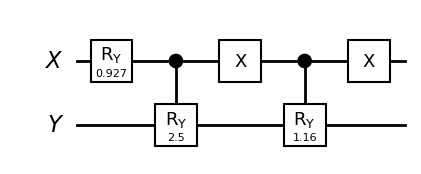

In [3]:
from qiskit import QuantumRegister
from qiskit import QuantumCircuit

# Define quantum registers
qrX = QuantumRegister(1, name="X")
qrY = QuantumRegister(1, name="Y")
# Define a 2-qubit quantum circuit
qc_2n = QuantumCircuit(qrX, qrY, name="Bayes net small")
# Apply the R_Y_theta rotation gate on the first qubit
qc_2n.ry(theta_X, 0)
# Apply the controlled-R_Y_theta rotation gate
qc_2n.cry(theta_Y_X, control_qubit=qrX, target_qubit=qrY)
# Apply the X gate on the first qubit
qc_2n.x(0)
# Apply the controlled-R_Y_theta rotation gate
qc_2n.cry(theta_Y_nX, control_qubit=qrX, target_qubit=qrY)
# Apply another X gate on the first qubit
qc_2n.x(0)
qc_2n.draw("mpl", style="bw", plot_barriers=False, justify="none", fold=-1)

#### 2.2.2. Burglary Alarm Example

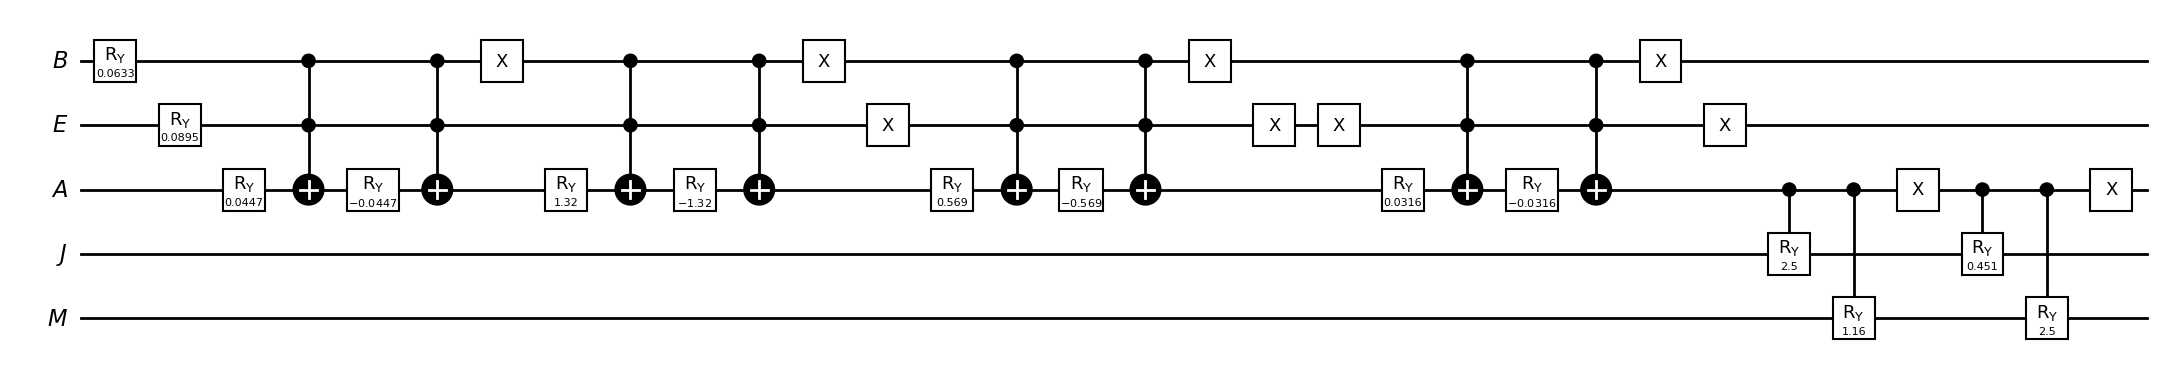

In [4]:
# Initialize register
var = ["B", "E", "A", "J", "M"]
qr = [QuantumRegister(1, name=v) for v in var]
qc_ba = QuantumCircuit(*qr, name="State preparation")
# Specify control qubits
# P(B)
qc_ba.ry(theta_B, qr[0])
# P(E)
qc_ba.ry(theta_E, qr[1])
# P(A|B,E)
qc_ba.mcry(theta_E, [qr[0][0], qr[1][0]], qr[2])
# P(A|-B,E)
qc_ba.x(qr[0])
qc_ba.mcry(theta_A_BnE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[0])
# P(A|B,-E)
qc_ba.x(qr[1])
qc_ba.mcry(theta_A_nBE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[1])
# P(A|-B,-E)
qc_ba.x(qr[0])
qc_ba.x(qr[1])
qc_ba.mcry(theta_A_nBnE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[0])
qc_ba.x(qr[1])
# P(J|A)
qc_ba.cry(theta_J_A, qr[2], qr[3])
# P(M|A)
qc_ba.cry(theta_M_A, qr[2], qr[4])
# P(J|-A) + P(M|-A)
qc_ba.x(qr[2])
qc_ba.cry(theta_J_nA, qr[2], qr[3])
qc_ba.cry(theta_M_nA, qr[2], qr[4])
qc_ba.x(qr[2])
# Draw circuit
qc_ba.draw("mpl", style="bw", plot_barriers=False, justify="none", fold=-1)

## 3. How to Run Rejection Sampling

### 3.1. Set up

Rejection sampling is a basic technique used in probabilistic computing for generating observations from a distribution. It's particularly useful when direct sampling from the desired distribution is difficult. The core idea is to use a simpler distribution (referred to as the proposal distribution) from which we can easily sample, and then to "reject" or "accept" these samples based on a certain criterion (evidence) so that the accepted samples follow the desired target distribution. 

Quantum rejection sampling adapts the classical rejection sampling method to the quantum computing context, utilizing quantum algorithms and states to perform efficient sampling. Once the state is prepared by the given quantum circuit representing the Bayesian network, it is measured, resulting in the collapse to one of its possible outcomes. This step is analogous to drawing a sample in classical rejection sampling. However, quantum rejection sampling primarily focuses on post-selection, where only specific measurement outcomes that meet desired criteria, here evidence, are retained, and others are disregarded.

In this implementation, Grover's algorithm is employed for amplitude amplification. This step is designed to increase the probability amplitudes of the desired outcomes, thereby reducing the number of samples needed. The efficiency of quantum rejection sampling lies in its utilization of quantum parallelism, which allows for the simultaneous evaluation of multiple probabilities, and quantum interference, which can be used to increase the likelihood of obtaining desired outcomes.

Quantum rejection sampling is particularly beneficial in complex or high-dimensional probability distribution scenarios, where classical computers face challenges. Its applications extend to quantum machine learning, probabilistic modeling, and other areas of quantum computing. 

To use the `QBayesian` class, instantiate it with a quantum circuit that represents the Bayesian network. You can then use the rejection sampling method to estimate probabilities given evidence.

#### 3.1.1 Two Node Bayesian Network Example
If we want to carry out a rejection sampling with X=1 as evidence, we can do this in the following way:

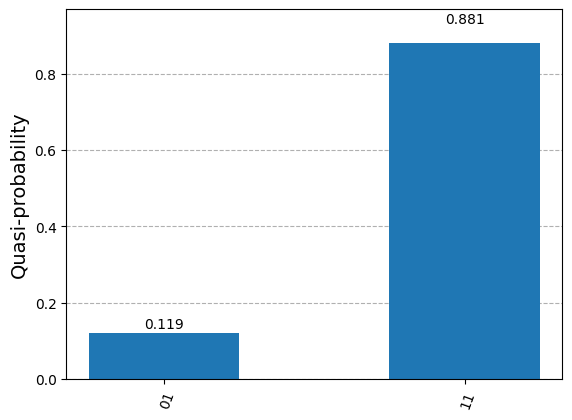

In [5]:
from qiskit_machine_learning.algorithms import QBayesian
from qiskit.visualization import plot_histogram
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
evidence = {"X": 1}
# Initialize QBayesian
qb_2n = QBayesian(circuit=qc_2n, sampler=sampler)
# Sampling
samples = qb_2n.rejection_sampling(evidence=evidence)
plot_histogram(samples)

We can also set the threshold to accept the evidence. For example, if set to 0.9, this means that each evidence qubit must be equal to the value of the evidence variable at least 90% of the time in order to be accepted. Sometimes we can also improve our result by setting the threshold for acceptance of the evidence higher:

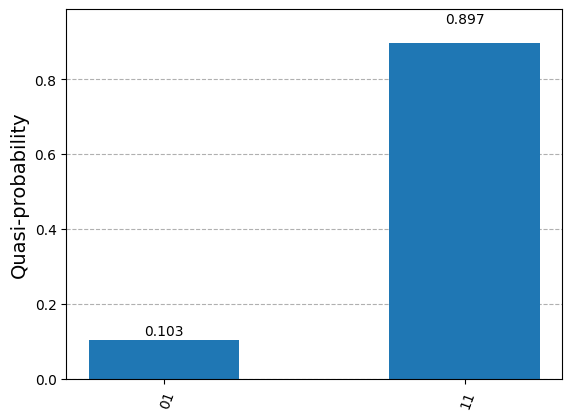

In [6]:
# Sampling
qb_2n.threshold = 0.97
samples = qb_2n.rejection_sampling(evidence=evidence)
plot_histogram(samples)

We can also print the result in a better format to understand which values belong to which variables:

In [7]:
qb_2n.threshold = 0.97
samples = qb_2n.rejection_sampling(evidence=evidence, format_res=True)
print(samples)

{'P(Y=0|X=1)': 0.1142578125, 'P(Y=1|X=1)': 0.8857421875}


#### 3.1.2. Burglary Alarm Example
For the advanced example, we can follow the steps from above in the same way. However, we look at the trivial case of how to obtain the joint probability of the network. This can be calculated by providing no evidence for the rejection sampling method. (For optical reasons, we only plot probabilities that are greater than 0.01%.)

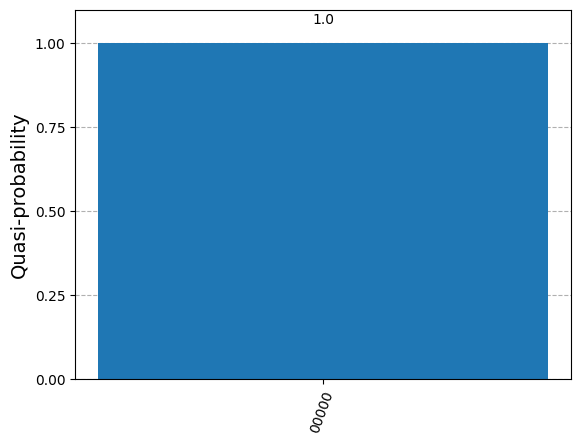

In [8]:
# Initialize quantum bayesian inference framework
qb_ba = QBayesian(circuit=qc_ba, sampler=sampler)
# Inference
counts = qb_ba.rejection_sampling(evidence={})
plot_histogram({c_key: c_val for c_key, c_val in counts.items() if c_val > 0.0001})

## 4. How to Run an Inference

### 4.1 Set Up
Quantum Bayesian inference is here based on quantum rejection sampling. Quantum rejection sampling plays a pivotal role in the inference process that follows. After the quantum state is manipulated to include evidence, measurement is performed. However, in quantum rejection sampling, only those measurement outcomes that align with the evidence are considered, effectively 'rejecting' irrelevant outcomes, similar to the traditional rejection sampling method.

The synergy of quantum state manipulation with quantum rejection sampling leads to a more efficient inference process compared to classical approaches, harnessing the inherent parallelism of quantum computing to simultaneously process multiple probabilities. This advanced method has significant implications in areas like quantum machine learning and data analysis, where it could outperform classical algorithms in tasks such as pattern recognition and decision-making.

You can use the `inference` method from `QBayesian` to estimate probabilities given evidence.

#### 4.1. Two Node Bayesian Network Example
Using `QBayesian`, you can draw various probabilistic conclusions. For the Bayesian network with two nodes, this is limited due to the number of variables. However, if we want to know what the probability of P(Y=0|X=1) is, we can do the following:

In [9]:
query = {"Y": 0}
evidence = {"X": 1}
# Inference
qb_2n.inference(query=query, evidence=evidence)

0.1083984375

#### 4.2. Burglary Alarm Example

Here we have more options to choose from. For example, if John calls, you can calculate the probability of a burglary having occurred. Bayesian networks are particularly useful in such scenarios where you have uncertain information (like John calling) and you want to infer the state of a more fundamental variable (like a burglary).

In [10]:
query = {"B": 1}
evidence = {"J": 1}
# Inference
qb_ba.inference(query=query, evidence=evidence)

0.0

We can also set the threshold to accept the evidence higher for the inference, and sometimes we can also improve our result by setting the evidence acceptance threshold higher:

In [11]:
# Inference
qb_ba.threshold = 0.97
qb_ba.inference(query=query, evidence=evidence)

0.0

And we can also check whether the algorithm converges:

In [12]:
print("Converged: ", qb_ba.converged)

Converged:  True
